## Demonstrating Mixture Models
Liberally adapted from **Antonino Ingargiola**'s [github page](https://github.com/tritemio).


**[This notebook is originally from Dr. Chandola's version of 474/574](https://nbviewer.org/github/ubdsgroup/ubmlcourse/tree/master/notebooks/)**


### Need for mixture models
We first demonstrate the need for a mixture model over a single model using a simple one dimensional example. Note that fitting a single Gaussian works well if the observed data "follows" that assumption. However, if the data has two (or more modes), using a single Gaussian does not work. 

In [89]:
import numpy as np
import scipy.stats as st
from scipy.stats import norm,bernoulli
from scipy.optimize import minimize, show_options
from mpl_toolkits.mplot3d import Axes3D
#from sklearn import mixture
import matplotlib.pyplot as plt
import csv
import math
%matplotlib inline

#### Sampling from a mixture model

In [90]:
# generate data again
N = 1000
pi = 0.5
mu1 = 0
sigma1 = 0.05
mu2 = 0.6
sigma2 = 0.08
samples = []
for i in range(N):
    s = bernoulli.rvs(pi,size=1)
    if s == 1:
        v = norm(mu1, sigma1).rvs(1)
    else:
        v = norm(mu2, sigma2).rvs(1)
    samples.append(v[0])
    

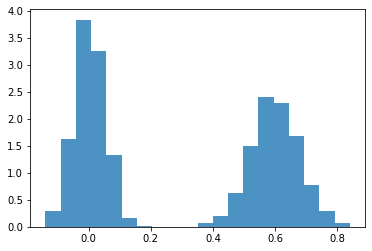

In [91]:
h1 = plt.hist(np.array(samples), bins=20,density=True,histtype='stepfilled',alpha=0.8);

#### Learning parameters for a distribution using MLE

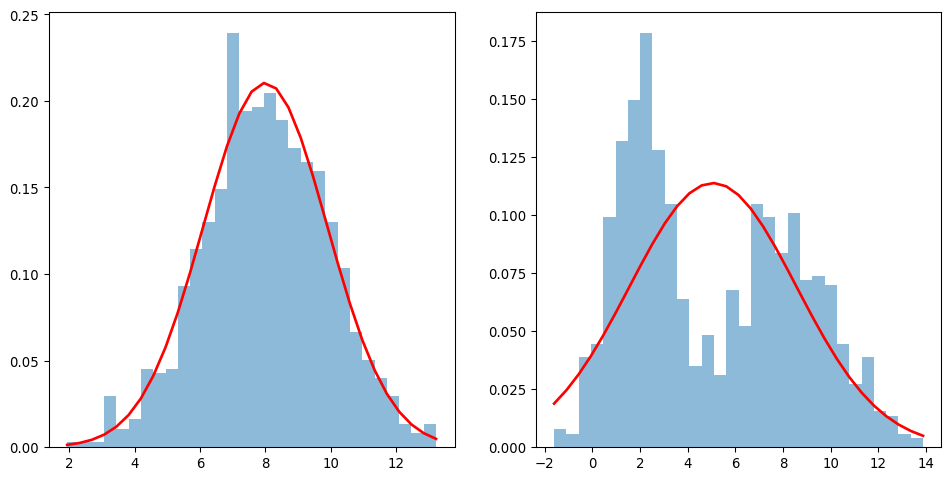

In [92]:
# first load two data sets
single = []
with open('single.dat') as f:
    for line in f:
        single.append(float(line.strip()))
s = np.array(single)
double = []
with open('double.dat') as f:
    for line in f:
        double.append(float(line.strip()))
d = np.array(double)

# plot the empirical distribution and the fitted single Gaussians
fig = plt.figure(num=None, figsize=(12, 6), dpi=96, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,2,1)
cnt,bins,ignored = ax.hist(s,30,density=True,histtype='stepfilled',alpha=0.5)
mu, sigma = norm.fit(single)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')

ax = fig.add_subplot(1,2,2)
cnt,bins,ignored = ax.hist(d,30, density=True,histtype='stepfilled',alpha=0.5)
mu, sigma = norm.fit(double)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')


The model for this sample is the linear combination of two Gaussian PDF:

$$p(x|\theta) = \frac{\pi_1}{\sigma_1\sqrt{2\pi}} {\rm exp} \left\{ -\frac{(x-\mu_1)^2}{2\sigma_1^2} \right\} +
\frac{\pi_2}{\sigma_2\sqrt{2\pi}} {\rm exp} \left\{ -\frac{(x-\mu_2)^2}{2\sigma_2^2} \right\}$$

where $\theta = [\mu_1, \sigma_1, \mu_2, \sigma_2, \pi_1]$. 
Note that $\pi_2$ is not included in $\theta$ since $\pi_2 = 1-\pi_1$.



In python we can define $f(x|\theta)$ using `normpdf()` implemented by *Numpy*: 

In [93]:
def pdf_model(x, theta):
    mu1, sig1, mu2, sig2, pi_1 = theta
    return pi_1*norm.pdf(x, mu1, sig1) + (1-pi_1)*norm.pdf(x, mu2, sig2)

## Maximum Likelihood: direct maximization
>We first see how to estimate parameters for the mixture using a direct maxmization of the log likelihood.

Given a sample $X = \{x_i\}$ of size $N$ extracted from the mixture distribution, the likelihood function is

$$\mathcal{L(\theta,X)} = \prod_i p(x_i|\theta)$$

and the log-likelihood function is:

$$\ln \mathcal{L(\theta,X)} = \sum_i \ln p(x_i|\theta)$$

Now, since $p(\cdot)$ is the sum of two terms, the term $\log p(x_i|\theta)$ can't be simplified (it's the log of a sum). 
So for each $x_i$ we must compute the log of the sum of two exponetial. 
It's clear that not only the computation will be slow but also the numerical errors will be amplified.
Moreover, often the likelihood function has local maxima other than the global one
(in other terms the function is not convex).

In python the log-likelihood function can be defined as:

In [94]:
def log_likelihood_two_1d_gauss(theta, sample):
    return -np.log(pdf_model(sample, theta)).sum()

We now try to minimize using several options in the numpy.scipy.optimize function.

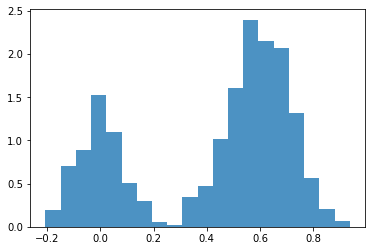

In [95]:
# generate data again
N = 1000
a = 0.3
s1 =  np.random.normal(0, 0.08, size=int(N*a))
s2 = np.random.normal(0.6,0.12, size=int(N*(1-a)))
d = np.concatenate([s1,s2])
plt.hist(d, bins=20,density=True,histtype='stepfilled',alpha=0.8);

In [96]:
# Initial guess
theta0 = np.array([-0.2,0.2,0.8,0.2,0.5])

In [97]:
# Minimization 1
res = minimize(log_likelihood_two_1d_gauss, x0=theta0, args=(d,), method='BFGS')
#res # NOT CONVERGED
res

      fun: nan
 hess_inv: array([[ 9.69043003e-01, -5.33011798e-02,  1.90251119e-01,
        -1.59948142e-01, -2.80936651e-02],
       [-5.33011798e-02,  9.64612168e-01,  1.58031997e-01,
        -8.56616729e-02,  9.11361160e-03],
       [ 1.90251119e-01,  1.58031997e-01,  3.40550955e-01,
         4.12494318e-01, -1.91092885e-04],
       [-1.59948142e-01, -8.56616729e-02,  4.12494318e-01,
         8.12030868e-01,  4.82802979e-02],
       [-2.80936651e-02,  9.11361160e-03, -1.91092885e-04,
         4.82802979e-02,  1.03311065e+00]])
      jac: array([nan, nan, nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 684
      nit: 2
     njev: 114
   status: 2
  success: False
        x: array([ 270.98565968,  -47.58917773, -118.17975305, -330.62865837,
       -278.14676583])

In [98]:
# Minimization 2
res = minimize(log_likelihood_two_1d_gauss, x0=theta0, args=(d,), method='powell',
        options=dict(maxiter=10e3, maxfev=2e4))
res # NOT CONVERGED

/var/folders/rf/4jz25sh1733_8b28phhhrlfh0000gn/T/ipykernel_91479/95324176.py:2: RuntimeWarning:

invalid value encountered in log



   direc: array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 121
     nit: 2
  status: 3
 success: False
       x: array([2.76103814, 1.1885009 , 5.97585792, 5.37585792, 5.67585792])

In [99]:
# Minimization 3
res = minimize(log_likelihood_two_1d_gauss, x0=theta0, args=(d,), method='Nelder-Mead',
        options=dict(maxiter=10e3, maxfev=2e4))
res

 final_simplex: (array([[-0.00250205,  0.08432967,  0.60029103,  0.11663857,  0.29973945],
       [-0.00249381,  0.08433316,  0.60029232,  0.11665726,  0.29968745],
       [-0.0025078 ,  0.08433115,  0.60030804,  0.11664547,  0.29981274],
       [-0.00251514,  0.08431211,  0.6003232 ,  0.11666425,  0.29978179],
       [-0.00246918,  0.08432749,  0.60027291,  0.1166453 ,  0.29970483],
       [-0.00251514,  0.08433913,  0.60028435,  0.11666049,  0.2997055 ]]), array([-220.08866079, -220.08865477, -220.08865224, -220.08863877,
       -220.08863764, -220.08863486]))
           fun: -220.08866078628924
       message: 'Optimization terminated successfully.'
          nfev: 374
           nit: 236
        status: 0
       success: True
             x: array([-0.00250205,  0.08432967,  0.60029103,  0.11663857,  0.29973945])

In [100]:
# Minimization 4
res = minimize(log_likelihood_two_1d_gauss, x0=theta0, args=(d,), method='L-BFGS-B',
    bounds=[(-0.5,2),(0.01,0.5),(-0.5,2),(0.01,0.5),(0.01,0.99)])
res

      fun: -220.0886764130582
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00078728,  0.01342926, -0.00895   ,  0.00469242, -0.00081002])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 348
      nit: 32
     njev: 58
   status: 0
  success: True
        x: array([ 0.60029734,  0.11665136, -0.0024949 ,  0.0843175 ,  0.70025079])

### Why is the mixture model log likelihood difficult to optimize
To answer this let us take the above data set with two modes. Let us assume that we know the true value for $\pi$, $\sigma_1$ and $\sigma_2$. Now, we will compute the negative log likelihood (the quantity that we want to *minimize*) for various values of $\mu_1$ and $\mu_2$. Remember that the true parameter values are:
0.3, 0.0, 0.08, 0.6, 0.12 for $\pi,\mu_1,\sigma_1,\mu_2,\sigma_2$, respectively.

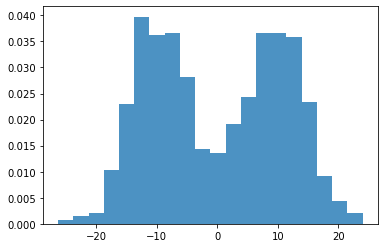

In [101]:
# generate data again
N = 1000
pi = 0.5
mu1 = -10
sigma1 = 5
mu2 = 10
sigma2 = 5
samples = []
for i in range(N):
    s = bernoulli.rvs(pi,size=1)
    if s == 1:
        v = norm(mu1, sigma1).rvs(1)
    else:
        v = norm(mu2, sigma2).rvs(1)
    samples.append(v[0])
plt.hist(samples, bins=20,density=True,histtype='stepfilled',alpha=0.8);    

In [102]:
mm1, mm2 = np.meshgrid(np.arange(-25,25, 0.1),
                     np.arange(-25,25, 0.1))
m1 = np.ravel(mm1)
m2 = np.ravel(mm2)

ll = []
print(len(m1))
for i in range(len(m1)):
    if i % 10000 == 0:
        print(i)
    theta = (m1[i], sigma1, m2[i], sigma2, pi)
    ll.append(-log_likelihood_two_1d_gauss(theta,samples))
ll = np.array(ll)

250000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000


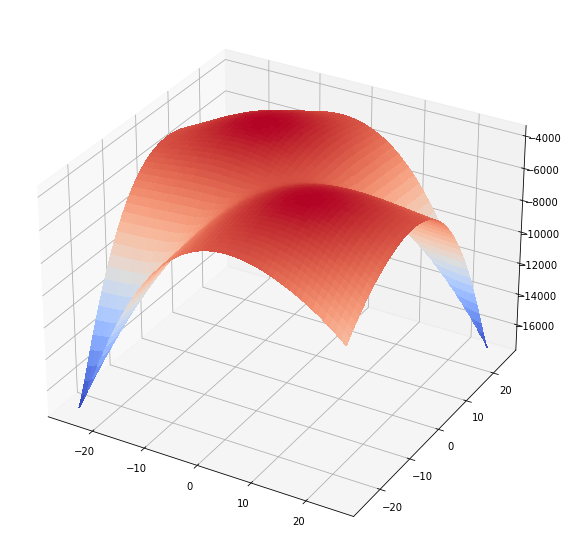

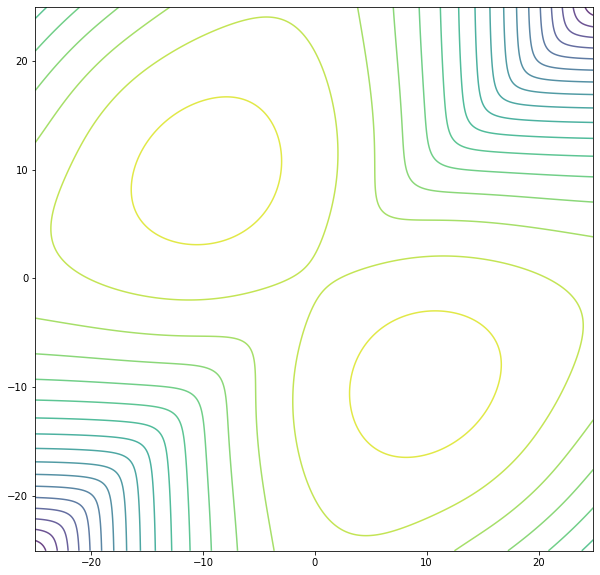

In [103]:
fig = plt.figure(figsize=[10,10])
cm = plt.cm.coolwarm

ax = fig.gca(projection='3d')

ll = np.array(ll)
llz = ll.reshape(mm1.shape)
surf = ax.plot_surface(mm1, mm2, llz, cmap=cm,
                       linewidth=0, antialiased=False)
plt.show()

fig = plt.figure(figsize=[10,10])
plt.contour(mm1, mm2, llz, 20,alpha=.8)


## Expectation Maximization
Now we will learn the parameters using the EM procedure for learning Gaussian mixtures.

Starting from the PDF $p_1()$ and $p_2()$ of the single components:

$$p_1(x|\theta) = \frac{1}{\sigma_1\sqrt{2\pi}} {\rm exp} \left\{ -\frac{(x-\mu_1)^2}{2\sigma_1^2} \right\}
\qquad
p_2(x|\theta) = \frac{1}{\sigma_2\sqrt{2\pi}} {\rm exp} \left\{ -\frac{(x-\mu_2)^2}{2\sigma_2^2} \right\}
$$

the mixture PDF is:

$$ p(x|\theta) = \pi_1 p(x|\theta_1) + \pi_2 p(x|\theta_2) $$

If we know (or guess initially) the parameters $\theta$, we can compute for each sample 
and each component the **responsibility function** defined as:
    
$$\gamma(i, k) =  \frac{\pi_kp(x_i|\theta_k)}{p(x_i|\theta)}$$

and starting from the "effective" number of samples for each category ($N_k$) we can compute the 
"new" estimation of parameters:
    
$$N_k = \sum_{i=1}^N \gamma(i, k)
\qquad\qquad
k=1,2
\quad
({\rm note\;that} \quad N_1 + N_2 = N)
$$

$$\mu_k^{new} = \frac{1}{N_k}\sum_{i=1}^N \gamma(i, k) \cdot s_i$$

$$\sigma_k^{2\,new} = \frac{1}{N_k}\sum_{i=1}^N \gamma(i, k) \cdot (s_i - \mu_k^{new})^2$$

$$\pi_k^{new} = \frac{N_k}{N}$$

Now we just loop 

 1. recompute $\gamma(i, k)$
 2. estimate updated parameters

until convergence.

In [104]:
d = np.array([2.3,3.2,3.1,1.6,1.9,11.5,10.2,12.3,8.6,10.9])

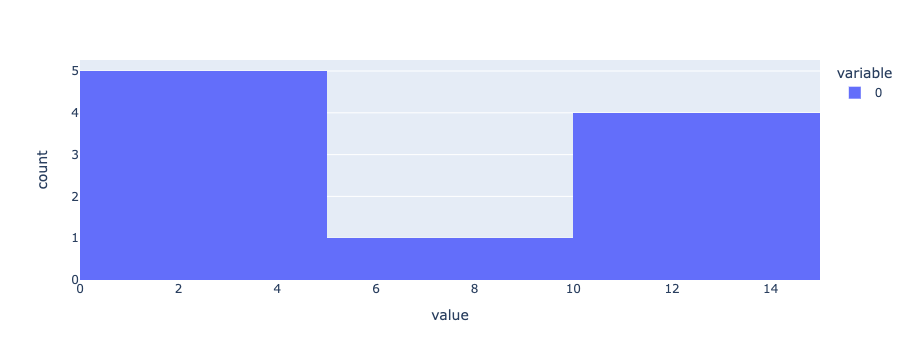

In [105]:
import plotly.express as px

px.histogram(d)

In [106]:
s = d
N = len(s)
max_iter = 4

# Initial guess of parameters and initializations
theta0 = np.array([0,1,1,1,0.5])
mu1, sig1, mu2, sig2, pi_1 = theta0
mu = np.array([mu1, mu2])
sig = np.array([sig1, sig2])
pi_ = np.array([pi_1, 1-pi_1])

gamma = np.zeros((2, s.size))
N_ = np.zeros(2)
theta_new = theta0

# EM loop
counter = 0
converged = False
while not converged:
    # Compute the responsibility func. and new parameters
    for k in [0,1]:
        # E Step
        gamma[k,:] = pi_[k]*norm.pdf(s, mu[k], sig[k])/pdf_model(s, theta_new)
        # M Step
        N_[k] = 1.*gamma[k].sum()
        mu[k] = sum(gamma[k]*s)/N_[k]
        #sig[k] = np.sqrt( sum(gamma[k]*(s-mu[k])**2)/N_[k] )
        sig[k] = np.sqrt((sum(gamma[k]*(s**2))/N_[k]) - mu[k]*mu[k])
        pi_[k] = N_[k]/s.size
    
    print(gamma)
    print(mu)
    print(sig**2)
    print(pi)
    #print('________')
    theta_new = [mu[0], sig[0], mu[1], sig[1], pi_[0]]
    assert abs(N_.sum() - N)/float(N) < 1e-6 
    assert abs(pi_.sum() - 1) < 1e-6
    
    # Convergence check
    counter += 1
    converged = counter >= max_iter

[[1.41851065e-01 6.29733561e-02 6.91384203e-02 2.49739894e-01
  1.97816111e-01 1.67014218e-05 6.12797396e-05 7.50450160e-06
  3.03447030e-04 3.04315569e-05]
 [8.58148935e-01 9.37026644e-01 9.30861580e-01 7.50260106e-01
  8.02183889e-01 9.99983299e-01 9.99938720e-01 9.99992495e-01
  9.99696553e-01 9.99969568e-01]]
[2.10736388 6.90646548]
[ 0.3362795  17.85441653]
0.5
[[4.92906833e-01 1.23704416e-01 1.64280376e-01 4.59682628e-01
  5.17629555e-01 1.10271145e-57 3.94326433e-43 1.05226627e-67
  3.69785578e-28 1.06050649e-50]
 [5.07093167e-01 8.76295584e-01 8.35719624e-01 5.40317372e-01
  4.82370445e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
[2.13729339 7.50348603]
[ 0.26553209 16.88097084]
0.5
[[7.83011651e-01 2.59831167e-01 3.45321303e-01 7.34942094e-01
  7.94972294e-01 5.61291784e-72 1.45378614e-53 1.16320814e-84
  1.23088686e-34 3.85217413e-63]
 [2.16988349e-01 7.40168833e-01 6.54678697e-01 2.65057906e-01
  2.05027706e-01 1.00000000e+00 1.00000000e

In [107]:
# print learnt parameters
print("Means:   %6.2f  %6.2f" % (theta_new[0], theta_new[2]))
print("Std dev: %6.2f  %6.2f" % (theta_new[1], theta_new[3]))
print("Mix (1): %6.2f " % theta_new[4])

Means:     2.31    9.31
Std dev:   0.61    3.22
Mix (1):   0.39 


In [108]:
def sim_two_gauss_mix(theta, N=1000): 
    x1 =  np.random.normal(theta[0], theta[1], size=int(N*theta[4]))
    x2 = np.random.normal(theta[2], theta[3], size=int(N*(1-theta[4])))
    x = np.concatenate([x1,x2])
    return x

In [109]:
d

array([ 2.3,  3.2,  3.1,  1.6,  1.9, 11.5, 10.2, 12.3,  8.6, 10.9])

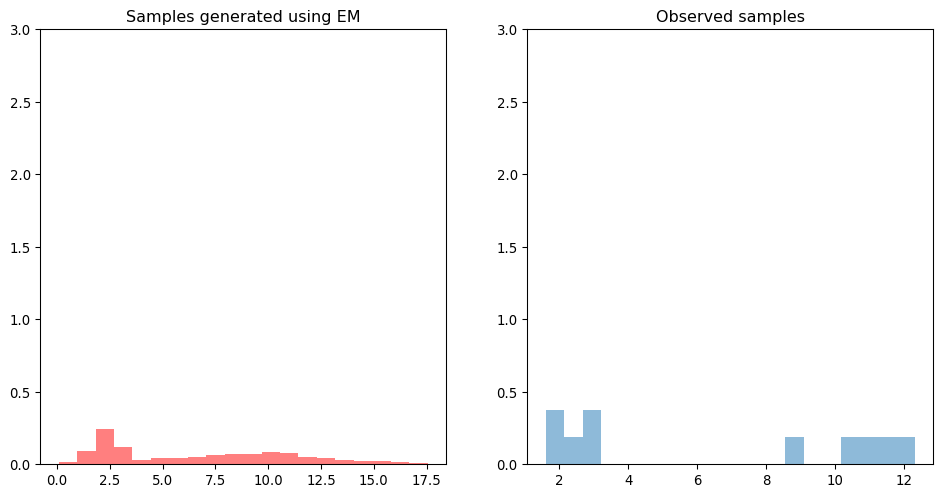

In [110]:
# draw samples from the learnt model and compare with the actual data
samples = sim_two_gauss_mix(theta_new)
fig = plt.figure(num=None, figsize=(12, 6), dpi=96, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,2,1)
ax.set_ylim((0,3))

ax.hist(samples, bins=20,density=True,histtype='stepfilled',alpha=0.5,color='r')
t1 = plt.title('Samples generated using EM')
ax = fig.add_subplot(1,2,2)
ax.set_ylim((0,3))
ax.hist(d, bins=20,density=True,histtype='stepfilled',alpha=0.5)
t2 = plt.title('Observed samples')

### Animated view of 2d mixture learning

In [111]:
def pltcontour(mu,sigma,ax,c):
    x1,x2 = np.mgrid[-3:3:.1, -3:3:.1]
    pos = np.dstack((x1, x2))
    rv = st.multivariate_normal(mu,sigma)
    levels = np.arange(-1.2, 1.6, 0.2)
    cn = ax.contour(x1, x2, rv.pdf(pos),1,colors=c,linewidth=16)
    return cn
    

In [115]:
import pandas as pd
# load old faithful data
data = pd.read_csv("https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv",
                  sep="\t")
data = np.array(data.values)
data = st.zscore(data)


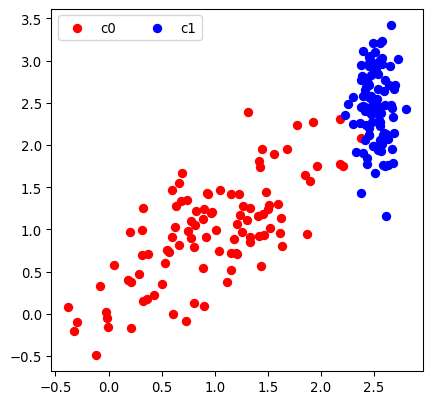

In [117]:


sigmas = [np.array([[0.3,0.2],[0.2,0.3]]),
          np.array([[0.01,0],[0,0.2]])
         ]
n = 100
mus = [ [1,1], [2.5,2.5]]
markers = [ ['r','+'], ['b','o']]

X = None
y = np.zeros([len(mus)*n,1])

fig = plt.figure(num=None, figsize=(5, 5), 
                 dpi=96, facecolor='w', edgecolor='k')

for i, mu in enumerate(mus):
    cluster_x = np.random.multivariate_normal(np.array(mu),
                                              sigmas[i],
                                              n)
    y[(i+1)*n:(i+2)*n] = i+1
    if X is not None:
        X = np.vstack([X,cluster_x])
    else:
        X = cluster_x

    plt.scatter(cluster_x[:,0],
                cluster_x[:,1],
                c=markers[i][0],
                marker='o')


plt.legend(['c'+str(i) for i in range(len(mus))],ncol=4,loc=2)

In [122]:
data = st.zscore(X)

/var/folders/rf/4jz25sh1733_8b28phhhrlfh0000gn/T/ipykernel_91479/3883038124.py:6: UserWarning:

The following kwargs were not used by contour: 'linewidth'



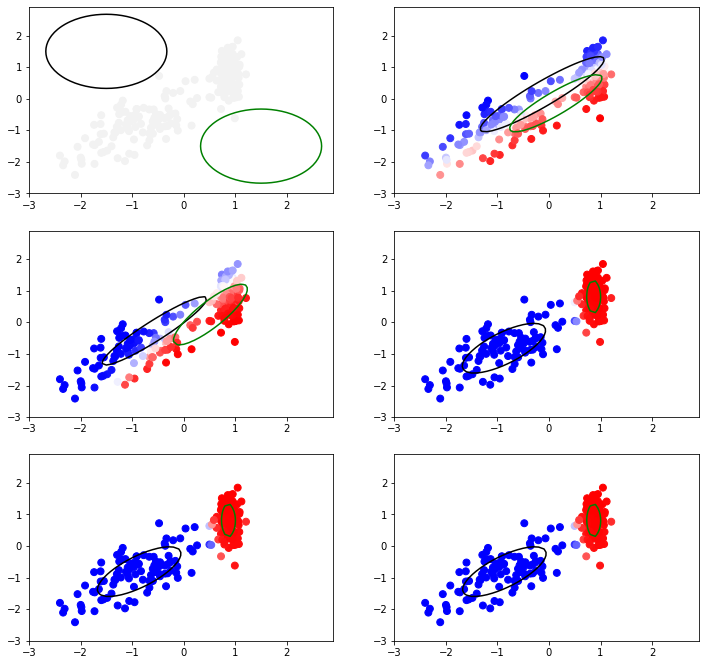

In [125]:
# initialize
mu1 = np.array([-1.5,1.5])
mu2 = np.array([1.5,-1.5])
sig1 = np.eye(2)
sig2 = np.eye(2)
pi = np.array([0.5,0.5])
mu = [mu1, mu2]
sig = [sig1, sig2]

# plot initial
fig = plt.figure(figsize=[12,24])
#ax = fig.gca()
cnt = 1
ax = plt.subplot(6,2,cnt)
colors = -1*np.ones([data.shape[0],])

ax.scatter(data[:,0],data[:,1],c=colors,s=48,cmap=plt.colormaps()[29])
# plot contours
pltcontour(mu[0],sig[0],ax,'k')
pltcontour(mu[1],sig[1],ax,'g')
# RUN EM

max_iter = 50
N_ = np.zeros(2)

## save data for animations
gammas = []
mus = []
sigs = []
# EM loop
for iters in range(max_iter):
    
    # E Step
    gamma = np.zeros([data.shape[0],2])
    rv0 = st.multivariate_normal(mu[0],sig[0])
    rv1 = st.multivariate_normal(mu[1],sig[1])

    pdfs1 = rv0.pdf(data)
    pdfs2 = rv1.pdf(data)
    den = pdfs1*pi[0] + pdfs2*pi[1]
    gamma[:,0] = (pdfs1*pi[0])/den
    gamma[:,1] = (pdfs2*pi[1])/den
    
    # M Step
    mu = []
    pi = np.sum(gamma,axis=0)/data.shape[0]
    N_ = 1.*np.sum(gamma,axis=0)
    mu.append(sum(np.tile(gamma[:,0:1],[1,2])*data)/N_[0])
    mu.append(sum(np.tile(gamma[:,1:2],[1,2])*data)/N_[1])

    s0 = np.zeros(sig[0].shape)
    s1 = np.zeros(sig[1].shape)
    
    for i in range(data.shape[0]):
        dm0 = (data[i,:] - mu[0])
        dm0 = dm0[:,np.newaxis]
        s0 = s0 + gamma[i,0]*np.dot(dm0,np.transpose(dm0))
        dm1 = (data[i,:] - mu[1])
        dm1 = dm1[:,np.newaxis]
        s1 = s1 + gamma[i,1]*np.dot(dm1,np.transpose(dm1))
    sig = []
    sig.append(s0/N_[0])
    sig.append(s1/N_[1])
    
    # plot every 10th iteration
    
    if iters%10 == 0:
        colors = -1*gamma[:,0] + 1*gamma[:,1]
        cnt = cnt + 1
        ax = plt.subplot(6,2,cnt)
        scat = ax.scatter(data[:,0],data[:,1],c=colors,s=48,cmap='bwr')
        # plot contours
        pltcontour(mu[0],sig[0],ax,'k')
        pltcontour(mu[1],sig[1],ax,'g')

    ## save data for animations
    gammas.append(gamma)
    sigs.append(sig)
    mus.append(mu)

